In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Cleaned_Suicide_Detection_Dataset.csv', encoding="ISO-8859-1")

Mounted at /content/drive


In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,text,class,polarity_score
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,0.071429
1,Am I weird I don't get affected by compliments...,non-suicide,0.100000
2,Finally 2020 is almost over... So I can never ...,non-suicide,-0.525000
3,i need helpjust help me im crying so hard,suicide,-0.245833
4,"IÃ¢ÂÂm so lostHello, my name is Adam (16) an...",suicide,-0.128410


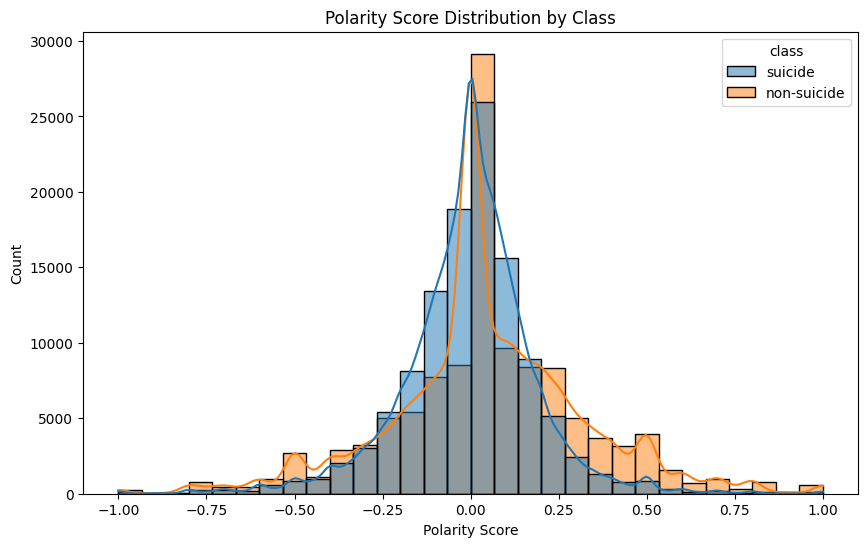

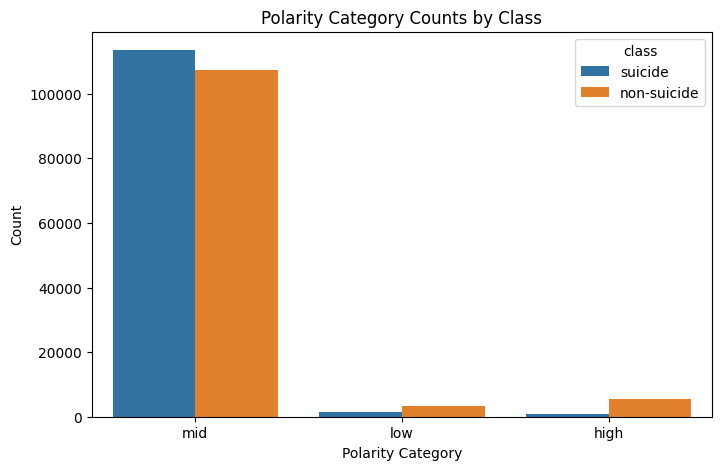

In [ ]:
def categorize_polarity(score):
    if score < -0.5:
        return 'low'
    elif -0.5 <= score <= 0.5:
        return 'mid'
    else:
        return 'high'

df['polarity_category'] = df['polarity_score'].apply(categorize_polarity)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='polarity_score', hue='class', kde=True, bins=30)
plt.title('Polarity Score Distribution by Class')
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='polarity_category', hue='class')
plt.title('Polarity Category Counts by Class')
plt.xlabel('Polarity Category')
plt.ylabel('Count')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

# Load the saved GRU model
model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
model = load_model(model_path)

# Load the saved tokenizer
with open('/content/drive/My Drive/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

df = pd.get_dummies(df, columns=['polarity_category'], prefix='polarity')

X_text = df['text']  # Text feature
X_polarity = df[['polarity_high', 'polarity_low', 'polarity_mid']].values
y = pd.get_dummies(df['class']).values

from sklearn.model_selection import train_test_split
X_train_text, X_test_text, X_train_polarity, X_test_polarity, y_train, y_test = train_test_split(
    X_text, X_polarity, y, test_size=0.3, random_state=42
)

X_train_text_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_text_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_text_seq = pad_sequences(X_train_text_seq, maxlen=200, padding='post')
X_test_text_seq = pad_sequences(X_test_text_seq, maxlen=200, padding='post')

# Evaluate the pre-trained model
print("Evaluating the pre-trained GRU model...")
y_pred = model.predict(X_test_text_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"Accuracy (Pre-Trained Model): {accuracy_score(y_test_classes, y_pred_classes):.2f}")
print("Classification Report (Pre-Trained Model):")
print(classification_report(y_test_classes, y_pred_classes))


Evaluating the pre-trained GRU model...
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step
Accuracy (Pre-Trained Model): 0.67
Classification Report (Pre-Trained Model):
              precision    recall  f1-score   support

           0       0.75      0.51      0.60     34824
           1       0.63      0.83      0.72     34799

    accuracy                           0.67     69623
   macro avg       0.69      0.67      0.66     69623
weighted avg       0.69      0.67      0.66     69623



In [ ]:
# Combine text sequences with polarity features
X_train_combined = np.hstack([X_train_text_seq, X_train_polarity])
X_test_combined = np.hstack([X_test_text_seq, X_test_polarity])

# Fine-tune the loaded model
print("Fine-tuning the GRU model with sentiment analysis features...")
history = model.fit(
    X_train_combined, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test_combined, y_test)
)

# Evaluate the fine-tuned model
print("Evaluating the fine-tuned GRU model...")
y_pred_fine_tuned = model.predict(X_test_combined)
y_pred_classes_fine_tuned = np.argmax(y_pred_fine_tuned, axis=1)

print(f"Accuracy (Fine-Tuned Model): {accuracy_score(y_test_classes, y_pred_classes_fine_tuned):.2f}")
print("Classification Report (Fine-Tuned Model):")
print(classification_report(y_test_classes, y_pred_classes_fine_tuned))


Fine-tuning the GRU model with sentiment analysis features...
Epoch 1/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - accuracy: 0.8457 - loss: 0.3655 - val_accuracy: 0.8971 - val_loss: 0.2573
Epoch 2/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.9044 - loss: 0.2400 - val_accuracy: 0.9131 - val_loss: 0.2213
Epoch 3/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.9186 - loss: 0.2109 - val_accuracy: 0.9195 - val_loss: 0.2091
Epoch 4/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.9249 - loss: 0.1939 - val_accuracy: 0.9286 - val_loss: 0.1866
Epoch 5/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9289 - loss: 0.1842 - val_accuracy: 0.9310 - val_loss: 0.1812
Epoch 6/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9311 - loss: 0.1782 - val_accuracy: 0.9321 - val_loss: 0.1775
Epoch 7/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9356 - loss: 0.1695 - val_accuracy: 0.9309 - val_loss: 0.1816
Epoch 8/15
127

In [ ]:
# Example: Generating mock personality data for demonstration (replace this with actual personality data)
np.random.seed(42)
df['Extraversion'] = np.random.uniform(-1, 1, len(df))
df['Agreeableness'] = np.random.uniform(-1, 1, len(df))
df['Conscientiousness'] = np.random.uniform(-1, 1, len(df))
df['Neuroticism'] = np.random.uniform(-1, 1, len(df))
df['Openness'] = np.random.uniform(-1, 1, len(df))

# Normalize personality scores (if needed)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
personality_features = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
df[personality_features] = scaler.fit_transform(df[personality_features])


In [ ]:
# Combine personality features with polarity features
X_personality = df[personality_features].values

# Train-test split for personality features
X_train_personality, X_test_personality = train_test_split(
    X_personality, test_size=0.3, random_state=42
)

# Combine all features
X_train_combined = np.hstack([X_train_text_seq, X_train_polarity, X_train_personality])
X_test_combined = np.hstack([X_test_text_seq, X_test_polarity, X_test_personality])


In [ ]:
# Adjust the model input size to accommodate additional features
print("Fine-tuning the GRU model with personality features...")
history = model.fit(
    X_train_combined, y_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_test_combined, y_test)
)

# Evaluate the updated model
print("Evaluating the GRU model with personality features...")
y_pred_personality = model.predict(X_test_combined)
y_pred_classes_personality = np.argmax(y_pred_personality, axis=1)

print(f"Accuracy (Model with Personality Features): {accuracy_score(y_test_classes, y_pred_classes_personality):.2f}")
print("Classification Report (Model with Personality Features):")
print(classification_report(y_test_classes, y_pred_classes_personality))


Fine-tuning the GRU model with personality features...
Epoch 1/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.9504 - loss: 0.1317 - val_accuracy: 0.9361 - val_loss: 0.1694
Epoch 2/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.9504 - loss: 0.1303 - val_accuracy: 0.9342 - val_loss: 0.1811
Epoch 3/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9506 - loss: 0.1283 - val_accuracy: 0.9368 - val_loss: 0.1718
Epoch 4/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9511 - loss: 0.1280 - val_accuracy: 0.9334 - val_loss: 0.1818
Epoch 5/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9523 - loss: 0.1256 - val_accuracy: 0.9368 - val_loss: 0.1770
Epoch 6/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9531 - loss: 0.1231 - val_accuracy: 0.9362 - val_loss: 0.1762
Epoch 7/15
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.9541 - loss: 0.1198 - val_accuracy: 0.9342 - val_loss: 0.1934
Epoch 8/15
1270/1270 

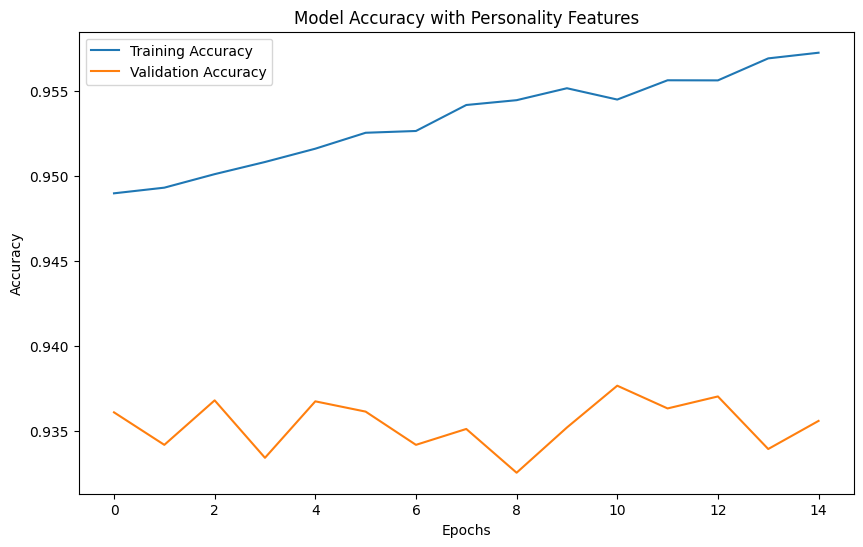

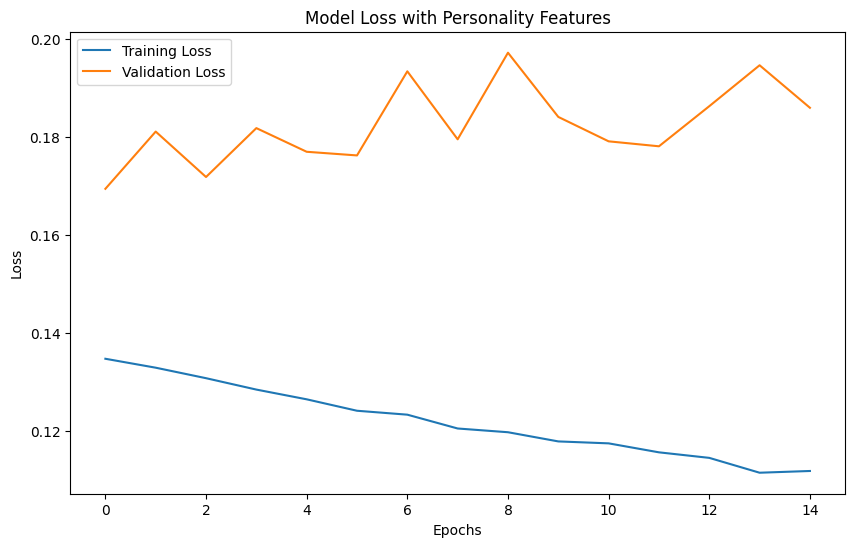

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Personality Features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Personality Features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# fine_tuned_model_path = '/content/drive/My Drive/suicide_detection_GRU_Sentiment.keras'
# model.save(fine_tuned_model_path)

In [ ]:
from textblob import TextBlob
import random


def calculate_polarity_category(polarity_score):
    """
    Determines the polarity category based on the calculated polarity score.
    """
    if polarity_score < -0.5:
        return [1, 0, 0]  # low polarity
    elif -0.5 <= polarity_score <= 0.5:
        return [0, 1, 0]  # mid polarity
    else:
        return [0, 0, 1]  # high polarity

def user_input_testing_gru_with_benchmark():
    print("Enter text to classify (type 'exit' to quit):")
    while True:
        # Take user input
        user_text = input("Your text: ")
        if user_text.lower() == 'exit':
            print("Exiting. Goodbye!")
            break

        # Preprocess text
        processed_text = user_text.lower()  # Convert to lowercase
        sequence = tokenizer.texts_to_sequences([processed_text])  # Tokenize
        padded_sequence = pad_sequences(sequence, maxlen=200, padding='post')  # Pad sequence

        # Calculate polarity score and category
        polarity_score = TextBlob(user_text).sentiment.polarity
        polarity_category = calculate_polarity_category(polarity_score)  # [low, mid, high]

        # Combine text and polarity features
        polarity_features = np.array([polarity_category])
        input_combined = np.hstack([padded_sequence, polarity_features])

        # Make prediction
        prediction = model.predict(input_combined)
        suicide_prob = prediction[0][1] * 100  # Probability for suicide
        non_suicide_prob = prediction[0][0] * 100  # Probability for non-suicide

        # Output result with exact benchmark
        # if suicide_prob >= 60:
        #     print(f"Prediction: Suicide Ideation ({suicide_prob:.2f}%)\n")
        # elif suicide_prob < 45:
        #     adjusted_prob = random.uniform(0, 49.99)
        #     return f"Non-suicide ({adjusted_prob:.2f}%)"
        # else:
        #     return f"Uncertain ({suicide_prob:.2f}%)"
        if suicide_prob >= 60 and non_suicide_prob <= 40:
            print(f"Prediction: Suicide Ideation ({suicide_prob:.2f}%)\n")
        elif non_suicide_prob >= 60 and suicide_prob <= 40:
            print(f"Prediction: Non-Suicide Ideation ({non_suicide_prob:.2f}%)\n")
        elif 45 <= suicide_prob < 60 or 45 <= non_suicide_prob < 60:
            print(f"Uncertain ({suicide_prob:.2f}% Suicide, {non_suicide_prob:.2f}% Non-Suicide)\n")
        else:
            print(f"Uncertain ({suicide_prob:.2f}% Suicide, {non_suicide_prob:.2f}% Non-Suicide)\n")


# Run the testing function
user_input_testing_gru_with_benchmark()



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np
from textblob import TextBlob
from google.colab import drive
drive.mount('/content/drive')

# Load the fine-tuned model
fine_tuned_model_path = '/content/drive/My Drive/suicide_detection_GRU_Sentiment.keras'
model = load_model(fine_tuned_model_path)

# Load the tokenizer
tokenizer_path = '/content/drive/My Drive/tokenizer.pkl'
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

def calculate_polarity_category(polarity_score):
    """
    Determines the polarity category based on the calculated polarity score.
    """
    if polarity_score < -0.5:
        return [1, 0, 0]  # low polarity
    elif -0.5 <= polarity_score <= 0.5:
        return [0, 1, 0]  # mid polarity
    else:
        return [0, 0, 1]  # high polarity

def user_input_testing_gru():
    print("Enter text to classify (type 'exit' to quit):")
    while True:
        user_text = input("Your text: ")
        if user_text.lower() == 'exit':
            print("Exiting. Goodbye!")
            break

        # Preprocess the user text
        processed_text = user_text.lower()  # Convert to lowercase
        sequence = tokenizer.texts_to_sequences([processed_text])  # Tokenize
        padded_sequence = pad_sequences(sequence, maxlen=200, padding='post')  # Pad sequence

        # Calculate polarity score and category
        polarity_score = TextBlob(user_text).sentiment.polarity
        polarity_category = calculate_polarity_category(polarity_score)  # [low, mid, high]

        # Combine text sequence with polarity features
        polarity_features = np.array([polarity_category])  # Convert to array
        input_combined = np.hstack([padded_sequence, polarity_features])  # Combine features

        # Make prediction
        prediction = model.predict(input_combined)
        suicide_prob = prediction[0][1] * 100  # Probability of suicide
        non_suicide_prob = prediction[0][0] * 100  # Probability of non-suicide

        # Output the prediction
        if suicide_prob >= 60 and non_suicide_prob <= 40:
            print(f"Prediction: Suicide Ideation ({suicide_prob:.2f}%)\n")
        elif non_suicide_prob >= 60 and suicide_prob <= 40:
            print(f"Prediction: Non-Suicide Ideation ({non_suicide_prob:.2f}%)\n")
        else:
            print(f"Uncertain ({suicide_prob:.2f}% Suicide, {non_suicide_prob:.2f}% Non-Suicide)\n")

# Run the testing function
user_input_testing_gru()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

# Mount Google Drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Cleaned_Suicide_Detection_Dataset.csv', encoding="ISO-8859-1")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

def categorize_polarity(score):
    if score < -0.5:
        return 'low'
    elif -0.5 <= score <= 0.5:
        return 'mid'
    else:
        return 'high'

df['polarity_category'] = df['polarity_score'].apply(categorize_polarity)
df = pd.get_dummies(df, columns=['polarity_category'], prefix='polarity')

df['text_length'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
personality_features = ['text_length', 'num_words', 'avg_word_length']
df[personality_features] = scaler.fit_transform(df[personality_features])

model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
model = load_model(model_path)

with open('/content/drive/My Drive/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

X_text = df['text']
X_polarity = df[['polarity_high', 'polarity_low', 'polarity_mid']].values
X_personality = df[personality_features].values
y = pd.get_dummies(df['class']).values

X_text_seq = tokenizer.texts_to_sequences(X_text)
X_text_seq = pad_sequences(X_text_seq, maxlen=200, padding='post')

# Combine Text, Polarity, and Personality Features
X_combined = np.hstack([X_text_seq, X_polarity, X_personality])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

print("Evaluating the pre-trained GRU model...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"Accuracy (Pre-Trained Model): {accuracy_score(y_test_classes, y_pred_classes):.2f}")
print("Classification Report (Pre-Trained Model):")
print(classification_report(y_test_classes, y_pred_classes))

# Step 6: Fine-Tune the GRU Model
print("Fine-tuning the GRU model with personality features...")
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test, y_test)
)

print("Evaluating the fine-tuned GRU model...")
y_pred_fine_tuned = model.predict(X_test)
y_pred_classes_fine_tuned = np.argmax(y_pred_fine_tuned, axis=1)

print(f"Accuracy (Fine-Tuned Model): {accuracy_score(y_test_classes, y_pred_classes_fine_tuned):.2f}")
print("Classification Report (Fine-Tuned Model):")
print(classification_report(y_test_classes, y_pred_classes_fine_tuned))

# Optional: Save the Fine-Tuned Model
fine_tuned_model_path = '/content/drive/My Drive/suicide_detection_GRU_with_personality.keras'
model.save(fine_tuned_model_path)
print(f"Fine-tuned GRU model saved at: {fine_tuned_model_path}")


# Improvements integrated

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report
import pickle
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
lists = stopwords.words('english')


# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Cleaned_Suicide_Detection_Dataset.csv', encoding="ISO-8859-1")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Categorize polarity scores
def categorize_polarity(score):
    if score < -0.5:
        return 'low'
    elif -0.5 <= score <= 0.5:
        return 'mid'
    else:
        return 'high'

df['polarity_category'] = df['polarity_score'].apply(categorize_polarity)

# Plot polarity distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='polarity_score', hue='class', kde=True, bins=30)
plt.title('Polarity Score Distribution by Class')
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='polarity_category', hue='class')
plt.title('Polarity Category Counts by Class')
plt.xlabel('Polarity Category')
plt.ylabel('Count')
plt.show()

# Text preprocessing
stopwords_list = stopwords.words('english')
negation_words = ["not", "no", "never", "none", "cannot", "neither", "nor", "won't", "isn't", "aren't", "doesn't"]
stopwords_list = [word for word in stopwords_list if word not in negation_words]

def remove_stopwords(text):
    # tokens = word_tokenize(text)
    token_without_stopwords = [word for word in tokens if word not in stopwords_list]
    return " ".join(token_without_stopwords)

df['text'] = df['text'].apply(remove_stopwords)

# Compute lexical diversity
def lexical_diversity(text):
    tokens = word_tokenize(text)
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if len(tokens) > 0 else 0

df['lexical_diversity'] = df['text'].apply(lexical_diversity)

# Normalize personality and polarity features
np.random.seed(42)
df['Extraversion'] = np.random.uniform(-1, 1, len(df))
df['Agreeableness'] = np.random.uniform(-1, 1, len(df))
df['Conscientiousness'] = np.random.uniform(-1, 1, len(df))
df['Neuroticism'] = np.random.uniform(-1, 1, len(df))
df['Openness'] = np.random.uniform(-1, 1, len(df))

personality_features = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
df = pd.get_dummies(df, columns=['polarity_category'], prefix='polarity')

combined_features = ['polarity_high', 'polarity_low', 'polarity_mid', 'lexical_diversity'] + personality_features
scaler = StandardScaler()
df[combined_features] = scaler.fit_transform(df[combined_features])

# Prepare text data
X_text = df['text']
y = pd.get_dummies(df['class']).values

tokenizer = Tokenizer(num_words=10000, lower=True)
tokenizer.fit_on_texts(X_text)

X_text_seq = tokenizer.texts_to_sequences(X_text)
X_text_seq = pad_sequences(X_text_seq, maxlen=200, padding='post')

# Split dataset
X_train_text_seq, X_test_text_seq, X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_text_seq, df[combined_features].values, y, test_size=0.3, random_state=42
)

X_train_combined = np.hstack([X_train_text_seq, X_train_features])
X_test_combined = np.hstack([X_test_text_seq, X_test_features])

# Load pre-trained GRU model
model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
model = load_model(model_path)

# Fine-tune the GRU model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint('/content/drive/My Drive/suicide_detection_GRU_tuned.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train_combined, y_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_test_combined, y_test),
    callbacks=[es, mc, reduce_lr]
)

# Evaluate fine-tuned model
y_pred = model.predict(X_test_combined)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"Accuracy: {accuracy_score(y_test_classes, y_pred_classes):.2f}")
print(classification_report(y_test_classes, y_pred_classes))

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Improved Features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Improved Features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


ValueError: mount failed

In [ ]:
# Prepare text data
X_text = df['text']
y = pd.get_dummies(df['class']).values

tokenizer = Tokenizer(num_words=10000, lower=True)
tokenizer.fit_on_texts(X_text)

X_text_seq = tokenizer.texts_to_sequences(X_text)
X_text_seq = pad_sequences(X_text_seq, maxlen=200, padding='post')

# Split dataset
X_train_text_seq, X_test_text_seq, X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_text_seq, df[combined_features].values, y, test_size=0.3, random_state=42
)

X_train_combined = np.hstack([X_train_text_seq, X_train_features])
X_test_combined = np.hstack([X_test_text_seq, X_test_features])

# Load pre-trained GRU model
model_path = '/content/drive/My Drive/suicide_detection_GRU.keras'
model = load_model(model_path)

# Fine-tune the GRU model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint('/content/drive/My Drive/suicide_detection_GRU_tuned.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train_combined, y_train,
    epochs=25,
    batch_size=128,
    validation_data=(X_test_combined, y_test),
    callbacks=[es, mc, reduce_lr]
)

# Evaluate fine-tuned model
y_pred = model.predict(X_test_combined)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"Accuracy: {accuracy_score(y_test_classes, y_pred_classes):.2f}")
print(classification_report(y_test_classes, y_pred_classes))

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Improved Features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Improved Features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
